In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%load_ext sql
%sql postgresql://localhost/bankcalls
%config SqlMagic.autopandas =  True

In [4]:
# sklearn stuff goes here
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics

# Load the columns that looked most promising in our EDA

In [5]:
%%sql  df_test << 
/*--  initial predictors looked interesting in the EDA notebook  --*/
SELECT 
/*-- categorical predictors --*/
       job, 
       contact, 
       month, 
       poutcome, 
        
/*-- integer predictors     --*/
       previous, 
        
/*-- float predictors       --*/
       cons_price_idx, 
       cons_conf_idx, 
       euribor3m,
    
/*-- target column          --*/
       success,
    
/*-- row id used for analysis of results --*/
       bank_addl_id
FROM  
       test_group
ORDER BY 
       bank_addl_id ASC;

 * postgresql://localhost/bankcalls
8238 rows affected.
Returning data to local variable df_test


In [6]:
%%sql  df_train << 
/*--  initial predictors looked interesting in the EDA notebook  --*/
SELECT 
/*-- categorical predictors --*/
       job, 
       contact, 
       month, 
       poutcome, 
        
/*-- integer predictors     --*/
       previous, 
        
/*-- float predictors       --*/
       cons_price_idx, 
       cons_conf_idx, 
       euribor3m,
    
/*-- target column          --*/
       success,
    
/*-- row id used for analysis of results --*/
       bank_addl_id
FROM  
       train_group
ORDER BY 
       bank_addl_id ASC;

 * postgresql://localhost/bankcalls
32950 rows affected.
Returning data to local variable df_train


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 10 columns):
job               41188 non-null object
contact           41188 non-null object
month             41188 non-null object
poutcome          41188 non-null object
previous          41188 non-null int64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
success           41188 non-null object
bank_addl_id      41188 non-null int64
dtypes: float64(3), int64(2), object(5)
memory usage: 3.1+ MB


## We can save some memory by hashing all the categorical predictors


In [42]:
df['job']      = df[     'job'].astype('category')
df['contact']  = df[ 'contact'].astype('category')
df['month']    = df[   'month'].astype('category')
df['poutcome'] = df['poutcome'].astype('category')

In [7]:
df_test['job']      = df_test[     'job'].astype('category')
df_test['contact']  = df_test[ 'contact'].astype('category')
df_test['month']    = df_test[   'month'].astype('category')
df_test['poutcome'] = df_test['poutcome'].astype('category')

In [8]:
df_train['job']      = df_train[     'job'].astype('category')
df_train['contact']  = df_train[ 'contact'].astype('category')
df_train['month']    = df_train[   'month'].astype('category')
df_train['poutcome'] = df_train['poutcome'].astype('category')

In [99]:
df_train.shape

(32950, 10)

### For the target column, change explicitly to 0 or 1

In [9]:
df_test['success'] =  df_test['success'].replace({'yes': 1, 'no': 0})
df_train['success'] =  df_train['success'].replace({'yes': 1, 'no': 0})

In [10]:
df.success.value_counts()

NameError: name 'df' is not defined

## And set the pandas index to match the postgres index

In [45]:
df.index = df.bank_addl_id

In [11]:
df_test.index = df_test.bank_addl_id

In [12]:
df_train.index = df_train.bank_addl_id

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 1 to 41188
Data columns (total 10 columns):
job               41188 non-null category
contact           41188 non-null category
month             41188 non-null category
poutcome          41188 non-null category
previous          41188 non-null int64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
success           41188 non-null int64
bank_addl_id      41188 non-null int64
dtypes: category(4), float64(3), int64(3)
memory usage: 2.4 MB


# Split into train and test data

In [47]:
y = df['success']
X = df.drop(columns='success')

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=33)

In [15]:
y_train = df_train['success']
X_train = df_train.drop(columns='success')

y_test = df_test['success']
X_test = df_test.drop(columns='success')

# Build a model 

## Preprocessing the inputs 

In [16]:
numerical = [ 'previous', 'cons_price_idx', 'cons_conf_idx', 'euribor3m' ]
categorical = [ 'job', 'contact', 'month', 'poutcome' ]

In [17]:
standard = StandardScaler()
X_train_scaled = standard.fit_transform(X_train[numerical])
X_test_scaled  = standard.transform(X_test[numerical])

/Users/jlc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jlc/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/jlc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
X_train_dummies = pd.get_dummies(X_train[categorical], drop_first=True)
X_test_dummies =  pd.get_dummies(X_test[categorical], drop_first=True)

In [19]:
X_train_onehot = X_train_dummies.values
X_test_onehot =  X_test_dummies.values

In [20]:
X_train_prepped = np.concatenate([X_train_scaled, X_train_onehot], axis = 1)
X_test_prepped  = np.concatenate([X_test_scaled, X_test_onehot], axis = 1)

coef_names = numerical + list(X_train_dummies.columns)

# Run a model

In [21]:
lr = LogisticRegressionCV(solver='lbfgs', cv=6, random_state=33, max_iter=250)
lr.fit(X_train_prepped, y_train)
lr.score(X_train_prepped, y_train)

0.8885280728376328

In [24]:
lr.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [110]:
y_train.index

Int64Index([    1,     2,     3,     4,     6,     7,     8,     9,    10,
               11,
            ...
            41176, 41177, 41178, 41179, 41180, 41181, 41183, 41186, 41187,
            41188],
           dtype='int64', name='bank_addl_id', length=32950)

In [87]:
y_train.index

Int64Index([    5,    13,    34,    39,    41,    53,    66,    69,    73,
               85,
            ...
            41162, 41164, 41168, 41171, 41173, 41174, 41175, 41182, 41184,
            41185],
           dtype='int64', name='bank_addl_id', length=8238)

In [55]:
X_train_prepped.shape

(32950, 27)

In [113]:
lr.intercept_

array([-2.05578361])

In [114]:
coef_table = pd.DataFrame(index=coef_names, data=lr.coef_.reshape(-1,1)).round(decimals=5)
coef_table

,0
previous,0.12909
cons_price_idx,-0.05777
cons_conf_idx,0.05514
euribor3m,-0.20481
job_blue-collar,-0.02480
job_entrepreneur,-0.00252
job_housemaid,-0.00086
job_management,-0.00103
job_retired,0.01577
job_self-employed,-0.00023


In [58]:
y_predict = lr.predict(X_train_prepped)

In [64]:
pd.DataFrame(data=X_train_prepped, columns=coef_names).describe().T

,count,mean,std,min,25%,50%,75%,max
previous,32950.0,7.541868e-16,1.000015,-0.351179,-0.351179,-0.351179,-0.351179,11.820642
cons_price_idx,32950.0,5.251422e-15,1.000015,-2.382414,-0.869377,0.297427,0.721562,2.059751
cons_conf_idx,32950.0,2.699611e-15,1.000015,-2.235469,-0.477394,-0.282053,0.889997,2.951936
euribor3m,32950.0,8.584265e-17,1.000015,-1.728835,-1.318812,0.709933,0.769992,0.818502
job_blue-collar,32950.0,2.264340e-01,0.418530,0.000000,0.000000,0.000000,0.000000,1.000000
job_entrepreneur,32950.0,3.465857e-02,0.182916,0.000000,0.000000,0.000000,0.000000,1.000000
job_housemaid,32950.0,2.619120e-02,0.159706,0.000000,0.000000,0.000000,0.000000,1.000000
job_management,32950.0,7.071320e-02,0.256349,0.000000,0.000000,0.000000,0.000000,1.000000
job_retired,32950.0,4.157815e-02,0.199626,0.000000,0.000000,0.000000,0.000000,1.000000
job_self-employed,32950.0,3.423369e-02,0.181832,0.000000,0.000000,0.000000,0.000000,1.000000


In [59]:
probs = pd.DataFrame(lr.predict_proba(X_train_prepped))

# Analyze metrics 

Due to the unbalanced classes, just predicting zeroes should be a very good prediction, so that will be the 
model to beat for the minimum viable project.

## Accuracy

In [60]:
metrics.accuracy_score(y_predict, y_train)

0.8991198786039454

In [61]:
just_guess_zeroes = np.zeros(len(y_train))

In [62]:
metrics.accuracy_score(just_guess_zeroes, y_train)

0.8874962063732929

## Confusion matrix

In [26]:
cm = metrics.confusion_matrix(y_train, y_predict)
pd.DataFrame(index=['actual_neg', 'actual_pos'], columns=['predict_neg', 'predict_pos'], data=cm)

,predict_neg,predict_pos
actual_neg,28822,421
actual_pos,2903,804


This is not a good result -- the actual_positives are far more likely to be 
predicted as negative, perhaps due to the unbalanced classes. Of course, the just
guess zeros model is worse! 

In [27]:
cm = metrics.confusion_matrix(y_train, just_guess_zeroes)
pd.DataFrame(index=['actual_neg', 'actual_pos'], columns=['zero_neg', 'zero_pos'], data=cm)

,zero_neg,zero_pos
actual_neg,29243,0
actual_pos,3707,0


## Classification Report

__micro__:  Calculate metrics globally by counting the total true positives, false negatives and false positives.

__macro__:  Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

__weighted__:  Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.


In [28]:
print(metrics.classification_report(y_train, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     29243
           1       0.66      0.22      0.33      3707

   micro avg       0.90      0.90      0.90     32950
   macro avg       0.78      0.60      0.64     32950
weighted avg       0.88      0.90      0.88     32950



__precision__:  What percent of what the model assigned label (0,1) is correctly labeled? 
- The just_guess_zeroes model is 89% precision for the 0 case. 89% of what's labeled 0 is actually a zero. 
Precision is undefined for the success case as there are no 1 predictions.

__recall__: What percent of the (0,1) population is correctly labeled? 
- The just_guess_zeroes model has 100% recall for the 0 label - all the 0 population is correctly labeled zero. 
It has 0% recall for the 1 label - all the 1 population in the test_y set is incorrectly labeled.

In [29]:
print(metrics.classification_report(y_train, just_guess_zeroes))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     29243
           1       0.00      0.00      0.00      3707

   micro avg       0.89      0.89      0.89     32950
   macro avg       0.44      0.50      0.47     32950
weighted avg       0.79      0.89      0.83     32950



/Users/jlc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jlc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jlc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## ROC Curves

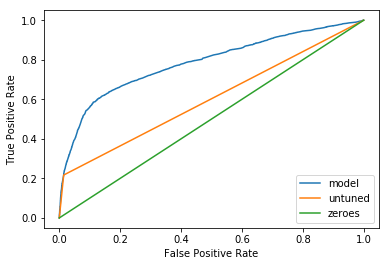

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(y_train,  probs.loc[:,1], pos_label=1)
plt.plot(fpr, tpr, label='model')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

fpr1, tpr1, _ = metrics.roc_curve(y_train, y_predict)
plt.plot(fpr1, tpr1, label='untuned')

fpr0, tpr0, thresholds0 = metrics.roc_curve(y_train, just_guess_zeroes, pos_label=1)
plt.plot(fpr0, tpr0,label='zeroes')
plt.legend(loc=4)

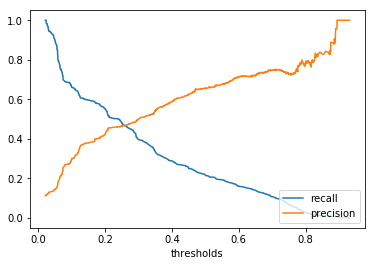

In [31]:
precision, recall, thresholds = metrics.precision_recall_curve(
    y_train, lr.predict_proba(X_train_prepped)[:,1], pos_label=1)
plt.plot(thresholds, recall[:-1], label='recall')
plt.plot(thresholds, precision[:-1], label='precision')
plt.xlabel("thresholds")
#fpr0, tpr0, thresholds0 = metrics.roc_curve(y_train, just_guess_zeroes)
#plt.plot(fpr0, tpr0,label='zeroes')
plt.legend(loc=4)

In [32]:
# And the area under the curve for the model and 
# the all-zeroes case

roc_auc = metrics.auc(fpr, tpr)
print("Model ROC AUC", roc_auc)

roc_auc = metrics.auc(fpr0, tpr0)
print("Zeroes ROC AUC", roc_auc)

Model ROC AUC 0.7840712476493329
Zeroes ROC AUC 0.5


# How do the missed positives vary from the positive population? 


In [33]:
y_predict = pd.Series(data=y_predict, index=y_train.index)
false_negative_ids = [ indx for indx in y_train.index if y_train[indx] == 1 and y_predict[indx] == 0 ] 
in_statement = 'bank_addl_id in ( ' + ", ".join([str(indx) for indx in false_negative_ids]) + ")"

 * postgresql://localhost/bankcalls
4 rows affected.
 * postgresql://localhost/bankcalls
4 rows affected.
 * postgresql://localhost/bankcalls
8 rows affected.
 * postgresql://localhost/bankcalls
8 rows affected.
 * postgresql://localhost/bankcalls
2 rows affected.
 * postgresql://localhost/bankcalls
2 rows affected.
 * postgresql://localhost/bankcalls
3 rows affected.
 * postgresql://localhost/bankcalls
3 rows affected.
 * postgresql://localhost/bankcalls
3 rows affected.
 * postgresql://localhost/bankcalls
3 rows affected.
 * postgresql://localhost/bankcalls
5 rows affected.
 * postgresql://localhost/bankcalls
5 rows affected.


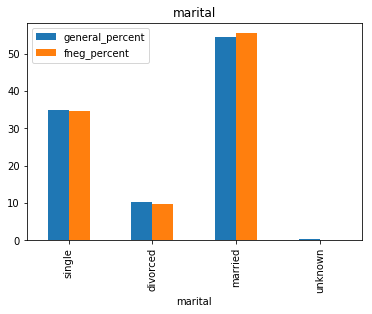

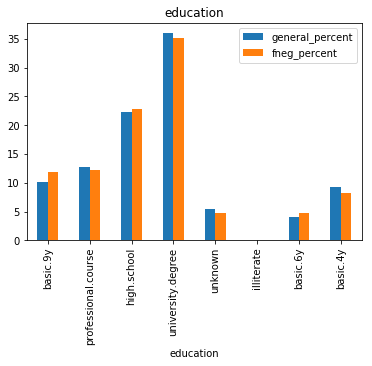

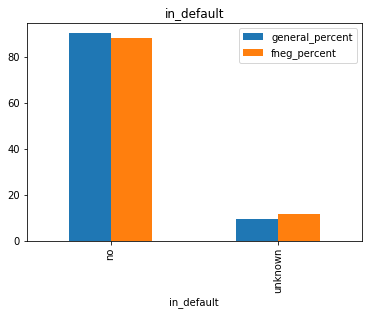

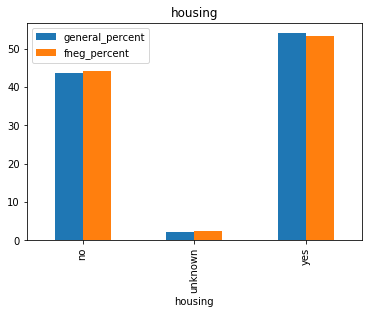

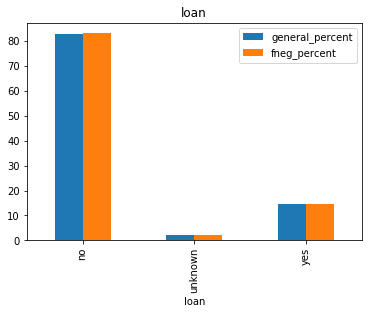

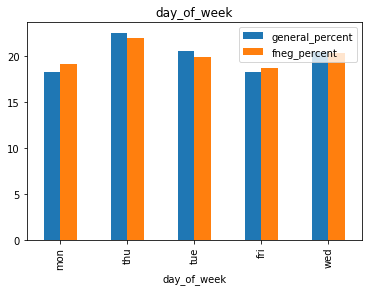

In [34]:
def analyze_categorical_false_negative(col, where_stmt):
    # sql the sums for the general positive population
    pop = %sql select $col, count($col) general_count from bank_addl where success = 'yes' group by $col;
    pop['general_percent'] = (100.0 * pop.general_count) /  np.sum(pop.general_count)
    pop.index = pop[col]
    
    # sql the sums for the false negative population
    fneg = %sql select $col, count($col) fneg_count from bank_addl col where $where_stmt group by $col;
    fneg['fneg_percent'] = (100.0 * fneg.fneg_count) /  np.sum(fneg.fneg_count)
    fneg.index = fneg[col]
    
    # join into one dataframe
    data = pd.concat([pop, fneg], axis=1)
    data = data[[col, 'general_percent', 'fneg_percent']]
    data.plot.bar().set_title(col)
    
    
analyze_categorical_false_negative('marital', in_statement)
analyze_categorical_false_negative('education', in_statement)
analyze_categorical_false_negative('in_default', in_statement)
analyze_categorical_false_negative('housing', in_statement)
analyze_categorical_false_negative('loan', in_statement)
analyze_categorical_false_negative('day_of_week', in_statement)


 * postgresql://localhost/bankcalls
4640 rows affected.
 * postgresql://localhost/bankcalls
2903 rows affected.


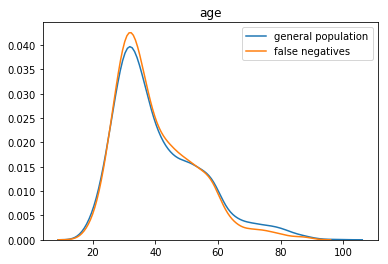

 * postgresql://localhost/bankcalls
4640 rows affected.
 * postgresql://localhost/bankcalls
2903 rows affected.


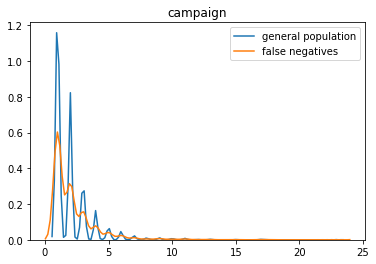

 * postgresql://localhost/bankcalls
4640 rows affected.
 * postgresql://localhost/bankcalls
2903 rows affected.


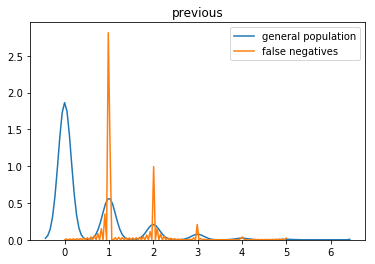

 * postgresql://localhost/bankcalls
4640 rows affected.
 * postgresql://localhost/bankcalls
2903 rows affected.


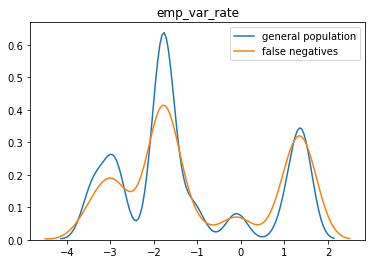

 * postgresql://localhost/bankcalls
4640 rows affected.
 * postgresql://localhost/bankcalls
2903 rows affected.


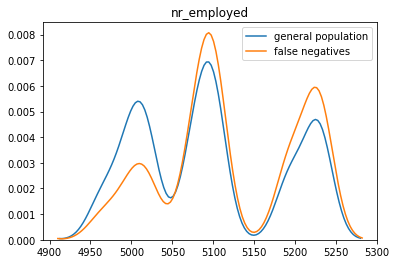

 * postgresql://localhost/bankcalls
4640 rows affected.
 * postgresql://localhost/bankcalls
2903 rows affected.


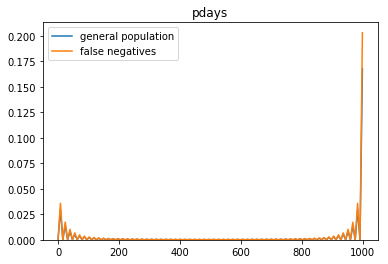

In [36]:
def analyze_numerical_false_negative(col, where_stmt):
    # sql the values for the column, general success population
    pop = %sql select $col general_population from bank_addl where success = 'yes'; 
    
    # sql the values for the false negative population
    fneg = %sql select $col false_negative from bank_addl where $where_stmt;
    
    # join into one dataframe
    sns.distplot(pop, hist=False, kde=True, label='general population' )
    sns.distplot(fneg, hist=False, kde=True, label='false negatives' )
    plt.title(col)
    plt.show()
    
    
analyze_numerical_false_negative('age', in_statement)
analyze_numerical_false_negative('campaign', in_statement)
analyze_numerical_false_negative('previous', in_statement)
analyze_numerical_false_negative('emp_var_rate', in_statement)
analyze_numerical_false_negative('nr_employed', in_statement)
analyze_numerical_false_negative('pdays', in_statement)


As I wrote in the EDA notebook, I need to be careful about adding these last two economic
factors to the notebook as there is at least some collinearity with euribor3m, but it looks like asking the model to consider 'campaign' and 'previous' may help it pick up some of the 
missed positives? 